In [26]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
from scipy.signal import convolve

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

import torch
import torch.nn as nn
import torch.optim as optim

import nibabel as nib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)



class ModelBOLD

Convolved BOLD Signal (y_conv): Should display peaks corresponding to the event onsets, shaped by the HRF.

Alignment Time (alignment_ts): Should show the same BOLD signal shifted forward by the specified hemodynamic delay, aligning the peak of the BOLD response with the appropriate neural event.

In [27]:
def visualize_data(first_data_x, first_data_y, participant_id, run_id):
    # Reshape X for plotting
    X_features = first_data_x.reshape(first_data_x.shape[0], -1)
    
    # Print shapes and data types
    print(f"X shape: {first_data_x.shape}, X dtype: {first_data_x.dtype}")
    print(f"y shape: {first_data_y.shape}, y dtype: {first_data_y.dtype}")
    
    # Display sample values
    print("\nSample values from X (first 5 time points):")
    print(first_data_x[:5])
    print("\nSample values from y (first 5 time points):")
    print(first_data_y[:5])
    
    # Plot voxel time series
    X_features = first_data_x.reshape(first_data_x.shape[0], -1)  # Make sure the shape is (time_points, num_voxels)
    plt.figure(figsize=(15, 10))  
    for voxel_idx in range(X_features.shape[1]):
        plt.plot(X_features[:, voxel_idx], label=f'Voxel {voxel_idx}')

    plt.title(f'All Voxel Time Series for {participant_id} {run_id}')
    plt.xlabel('Time Points')
    plt.ylabel('Voxel Intensity')
    plt.show()
    
    # Summary statistics
    y_values = first_data_y.flatten()
    voxel_columns = [f'voxel_{i}' for i in range(X_features.shape[1])]
    X_df = pd.DataFrame(X_features, columns=voxel_columns)
    X_df['y'] = y_values
    print("\nSummary Statistics of Voxel Features:")
    print(X_df.describe())
    
    # Correlation plot
    corr_matrix = X_df.corr()
    voxel_y_corr = corr_matrix['y'].drop('y')
    plt.figure(figsize=(12, 6))
    voxel_y_corr.plot(kind='bar')
    plt.title(f'Correlation Between Voxel Features and y for {participant_id} {run_id}')
    plt.xlabel('Voxel Features')
    plt.ylabel('Correlation Coefficient')
    plt.show()


Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005.nii <--> /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run005_orientations.csv
Matched: /Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run006.ni

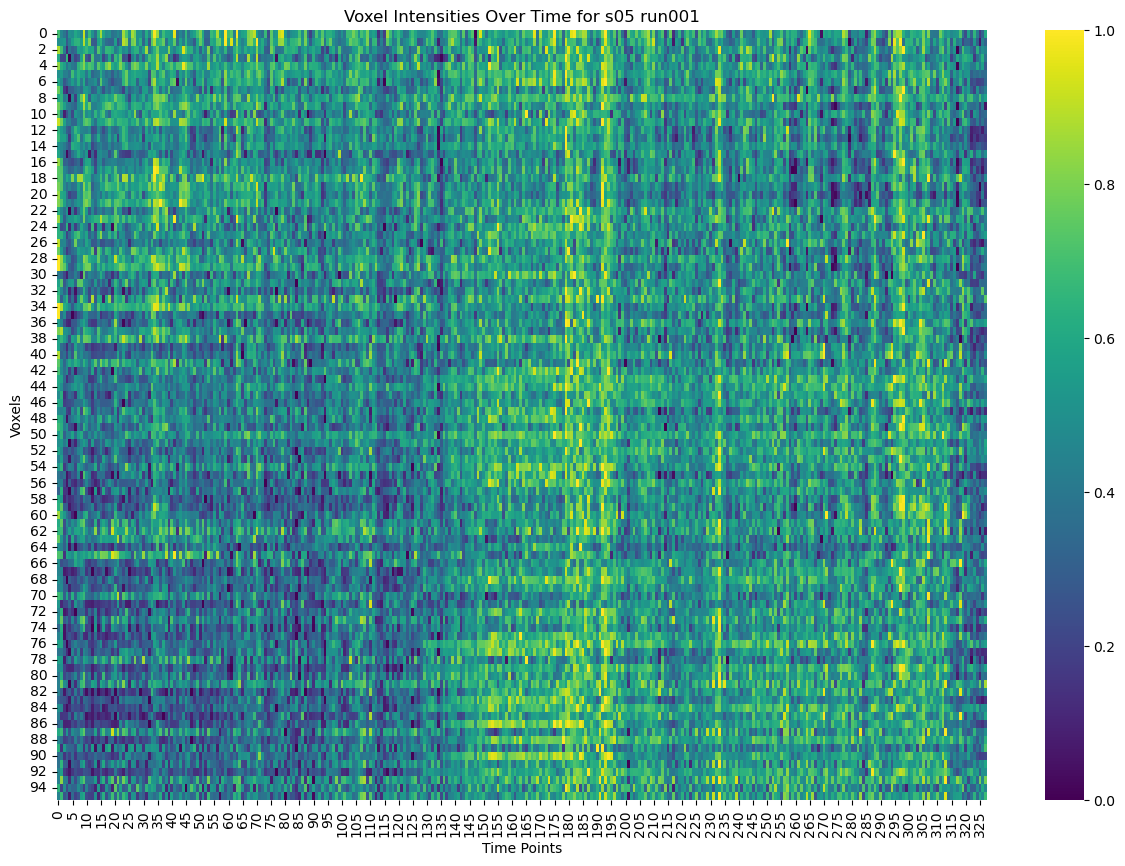

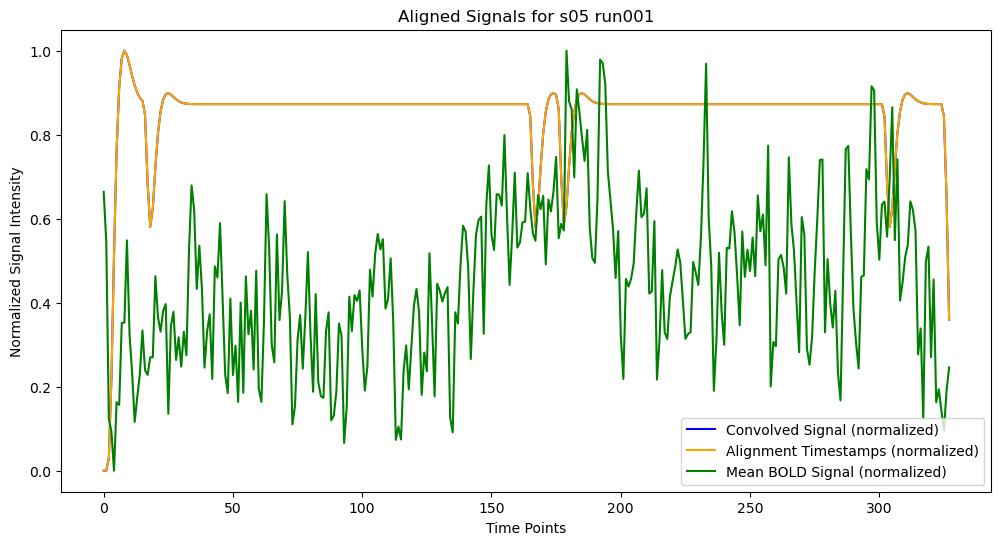

X shape: (328, 1, 97), X dtype: float32
y shape: (328, 1, 1), y dtype: float32

Sample values from X (first 5 time points):
[[[0.6925358  0.4903007  0.8721217  0.5999106  0.8346894  0.49984133
   0.5877312  0.77202266 0.5947581  0.7748009  0.7188755  0.9160126
   0.6449329  0.67399406 0.5113902  0.57673544 0.8434382  0.7406702
   0.7353497  0.7861702  0.84005713 0.8047932  0.6152463  0.8476155
   0.62573963 0.6341693  0.9035461  0.76755977 1.         1.
   0.39697543 0.5678934  0.6345268  0.6810062  1.         1.
   0.5545966  0.7987461  0.5818447  0.5723134  0.876502   0.7384403
   0.697121   0.59485847 0.5783769  0.47399703 0.5931241  0.4652441
   0.62837076 0.6792758  0.5482777  0.48966613 0.57053393 0.4264045
   0.53806114 0.3811189  0.41048333 0.30846062 0.61173266 0.6313832
   0.85211045 0.6078533  0.6459132  0.75717497 0.49036086 0.7161546
   0.4870829  0.44514108 0.4914319  0.44180584 0.6862399  0.5266612
   0.44681433 0.47506428 0.33180663 0.43566915 0.5581465  0.38027382
   0

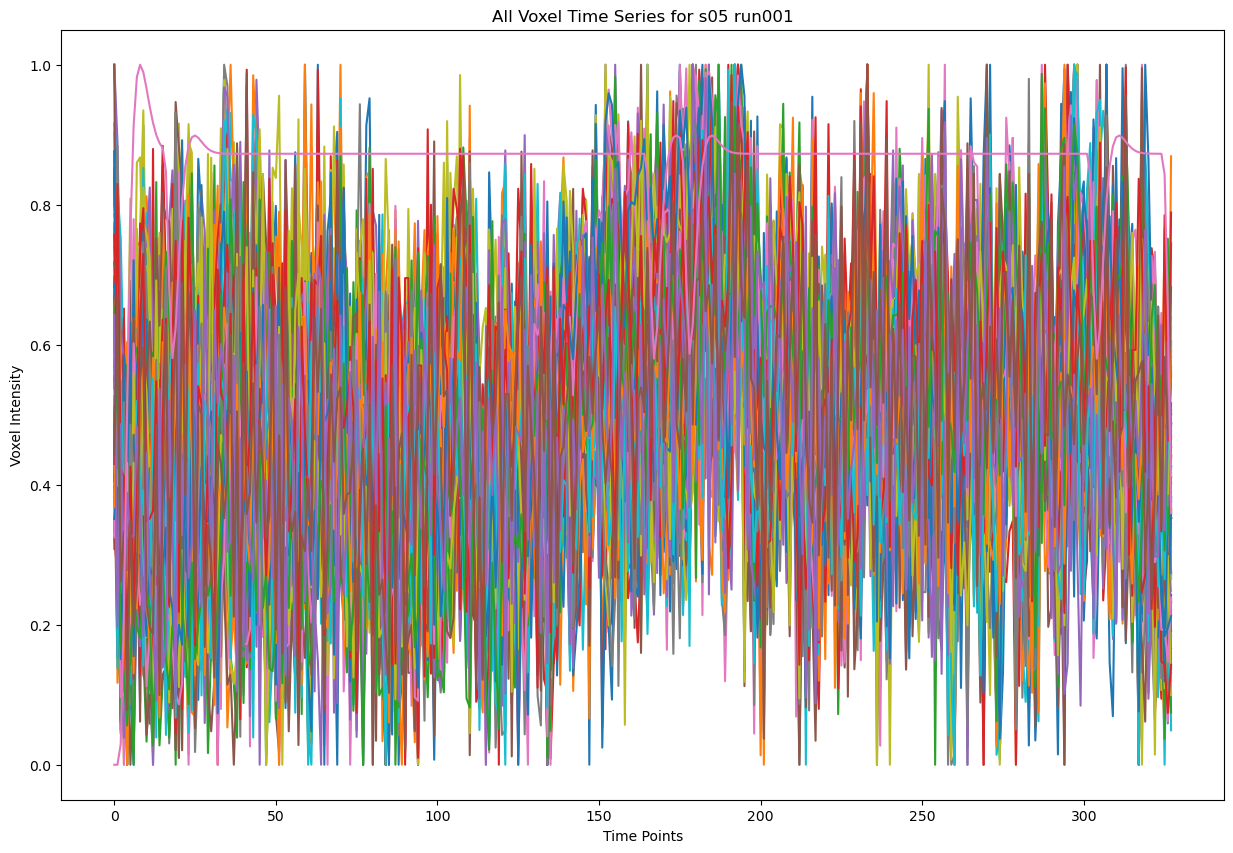


Summary Statistics of Voxel Features:
          voxel_0     voxel_1     voxel_2     voxel_3     voxel_4     voxel_5  \
count  328.000000  328.000000  328.000000  328.000000  328.000000  328.000000   
mean     0.576248    0.547320    0.536015    0.485744    0.571824    0.573372   
std      0.185272    0.187274    0.172649    0.192154    0.159549    0.137403   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.461691    0.412706    0.407895    0.347787    0.460429    0.487464   
50%      0.576866    0.556256    0.527961    0.486813    0.571930    0.574103   
75%      0.701928    0.678952    0.648026    0.617345    0.676405    0.666455   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

          voxel_6     voxel_7     voxel_8     voxel_9  ...    voxel_88  \
count  328.000000  328.000000  328.000000  328.000000  ...  328.000000   
mean     0.532101    0.465055    0.605744    0.513803  ...    0.501341   
std      

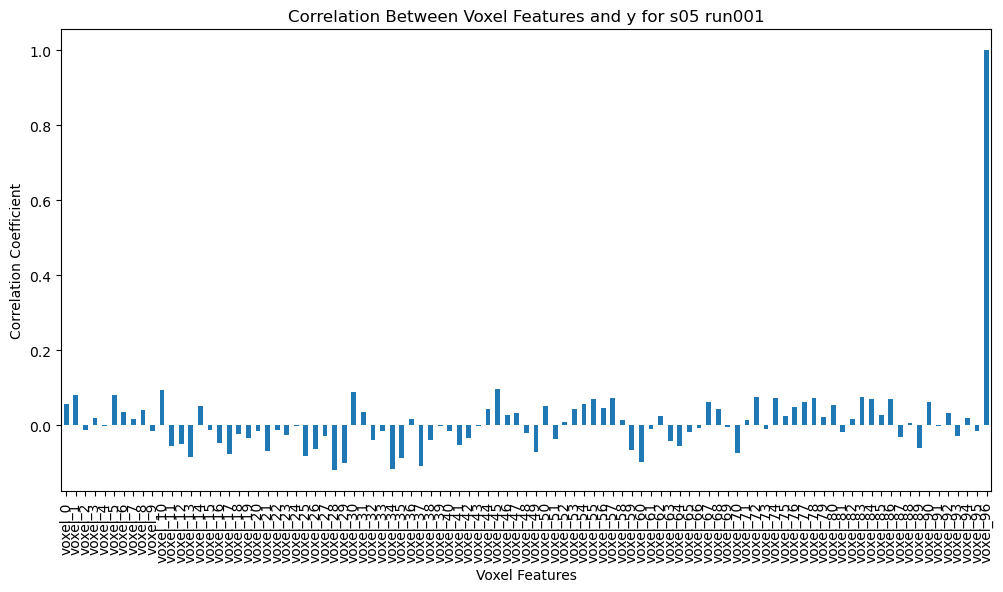


First Labels DataFrame:
   Orientation    y_conv  alignment_ts  voxel_4046  voxel_3646  voxel_3388  \
0      0.00000  0.000000      0.000000    0.692536    0.490301    0.872122   
1     10.78054  0.000000      0.000000    0.461691    0.509214    0.696135   
2     31.16449  0.029564      0.029564    0.394464    0.528128    0.416118   
3     15.54483  0.220565      0.220565    0.288680    0.282735    0.128289   
4     15.54483  0.513370      0.513370    0.500247    0.424345    0.384046   

   voxel_4550  voxel_2988  voxel_3666  voxel_4066  ...  voxel_3285  \
0    0.599911    0.834689    0.499841    0.587731  ...    0.324896   
1    0.225749    0.626109    0.549349    0.482634  ...    0.421190   
2    0.208315    0.561021    0.425897    0.271989  ...    0.096294   
3    0.651766    0.388683    0.431926    0.350925  ...    0.101514   
4    0.000000    0.474852    0.364011    0.429860  ...    0.106472   

   voxel_4887  voxel_3326  voxel_5330  voxel_3685  voxel_4908  voxel_4167  \
0    0.6

In [28]:
class ModelBOLD:
    @staticmethod
    def hrf(tr, duration=32.0):
        """
        Create a canonical Hemodynamic Response Function (HRF) using a double-gamma model.

        Args:
            tr (float): Repetition time (seconds).
            duration (float): Duration to model the HRF (seconds).

        Returns:
            hrf (numpy.ndarray): The HRF sampled at TR intervals.
        """
        # Parameters for the double-gamma HRF
        peak1 = 6
        undershoot = 16
        dispersion1 = 1
        dispersion2 = 1
        ratio = 6
        scale = 1

        t = np.linspace(0, duration, int(duration / tr))
        hrf = (gamma.pdf(t, peak1 / dispersion1, scale=dispersion1) -
               gamma.pdf(t, undershoot / dispersion2, scale=dispersion2) / ratio)
        hrf = hrf / np.max(hrf)  # Normalize
        return hrf

    @staticmethod
    def convolve_events_with_hrf(event_onsets, tr=1.5, duration=32.0, hemodynamic_delay=7.5):
        """
        Convolve event onsets with HRF and apply hemodynamic delay.

        Args:
            event_onsets (numpy.ndarray): Array of event onset times in seconds.
            tr (float): Repetition time (seconds).
            duration (float): Duration to model the HRF (seconds).
            hemodynamic_delay (float): Hemodynamic delay in seconds.

        Returns:
            y_conv (numpy.ndarray): The convolved and delayed BOLD signal.
            alignment_ts (numpy.ndarray): Alignment timestamps adjusted for hemodynamic delay.
        """
        # Generate HRF
        hrf = ModelBOLD.hrf(tr=tr, duration=duration)

        # Define total duration
        if len(event_onsets) == 0:
            print("No event onsets provided.")
            return np.array([]), np.array([])
        
        total_duration = event_onsets[-1] + duration
        num_time_points = int(np.ceil(total_duration / tr))
        time_vector = np.arange(0, num_time_points * tr, tr)

        # Create binary event series
        event_series = np.zeros_like(time_vector)
        for onset in event_onsets:
            idx = np.where(time_vector >= onset)[0]
            if len(idx) > 0:
                event_series[idx[0]] = 1  # Mark the first TR >= onset

        # Convolve event series with HRF
        y_conv_full = convolve(event_series, hrf)[:num_time_points]

        # Normalize y_conv
        if np.max(y_conv_full) != 0:
            y_conv = y_conv_full / np.max(y_conv_full)
        else:
            y_conv = y_conv_full

        # Alignment timestamps: align the convolved signal to BOLD data by applying hemodynamic delay
        delay_slices = int(hemodynamic_delay / tr)
        alignment_ts = np.pad(y_conv, (delay_slices, 0), 'constant')[:num_time_points]

        return y_conv, alignment_ts
    
def get_run_prefixes():
    """
    Generate run prefixes for participants s05 and s14.

    Returns:
        list: List of run prefixes.
    """
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 7)]  # s05_run001 to s05_run006
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 7)]  # s14_run002 to s14_run006
    return s05 + s14

def match_files(input_dir, prefixes):
    """
    Match NIfTI files with their corresponding CSV label files.

    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.

    Returns:
        list of tuples: Each tuple contains paths to a matched NIfTI and CSV file.
    """
    matched = []
    missing_files = {'nifti': [], 'csv': []}
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(input_dir, f"{prefix}_orientations.csv")
        nifti_exists = os.path.isfile(nifti_path)
        csv_exists = os.path.isfile(csv_path)

        if nifti_exists and csv_exists:
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            if not nifti_exists:
                missing_files['nifti'].append(nifti_path)
            if not csv_exists:
                missing_files['csv'].append(csv_path)

    if missing_files['nifti'] or missing_files['csv']:
        print(f"Warning: Missing NIfTI files: {missing_files['nifti']}")
        print(f"Warning: Missing CSV files: {missing_files['csv']}")

    return matched

def get_measurement_df(nifti_path, csv_path, required_columns, rows_per_slice, delay_rows, voxel_indices=None):
    """
    Load and process voxel and event data, applying hemodynamic delay.

    Args:
        nifti_path (str): Path to the NIfTI file.
        csv_path (str): Path to the CSV file.
        required_columns (set): Required columns in the CSV.
        rows_per_slice (int): Number of CSV rows per NIfTI slice.
        delay_rows (int): Number of rows to delay for hemodynamic alignment.
        voxel_indices (list of tuples, optional): Specific voxels to extract.

    Returns:
        tuple: (processed DataFrame, list of voxel column names)
    """
    # Load NIfTI data
    try:
        nii_img = nib.load(nifti_path)
        data = nii_img.get_fdata()  # Shape: (X, Y, Z, Time)
        print(f"Loaded NIfTI file: {nifti_path} with shape {data.shape}")
    except Exception as e:
        print(f"Error loading NIfTI file {nifti_path}: {e}")
        return None, []

    # Load CSV event data
    try:
        labels_df = pd.read_csv(csv_path)
        print(f"Loaded CSV file: {csv_path} with {len(labels_df)} entries")
    except Exception as e:
        print(f"Error loading CSV file {csv_path}: {e}")
        return None, []

    # Check for required columns
    if not required_columns.issubset(labels_df.columns):
        missing = required_columns - set(labels_df.columns)
        print(f"Error: Missing required columns {missing} in {csv_path}")
        return None, []

    slice_indices = np.arange(0, data.shape[-1])
    csv_indices = slice_indices * rows_per_slice

    # Ensure indices are within bounds
    valid_mask = (csv_indices >= 0) & (csv_indices < len(labels_df))
    csv_indices = csv_indices[valid_mask].astype(int)
    slice_indices = slice_indices[valid_mask]

    if len(csv_indices) == 0:
        print("Warning: No valid CSV indices after applying delay. Skipping this file.")
        return None, []

    # Extract filtered labels
    filtered_labels = labels_df.iloc[csv_indices].reset_index(drop=True)
    print(f"Filtered labels shape: {filtered_labels.shape}")

    # Extract 'Time' and 'Orientation'
    if 'Time' in required_columns:
        event_onsets = filtered_labels['Time'].astype(float).values  # Ensure 'Time' is float
    if 'Orientation' in required_columns:
        orientations = filtered_labels['Orientation'].values

    # Extract voxel data at slice_indices
    extracted_data = data[..., slice_indices]  # Shape: (X, Y, Z, num_slices)
    print(f"Extracted voxel data shape: {extracted_data.shape}")

    # Reshape voxel data to (num_slices, voxel_features)
    num_slices = extracted_data.shape[-1]
    voxel_features = extracted_data.transpose(3, 0, 1, 2).reshape(num_slices, -1)  # Shape: (num_slices, voxel_features)
    print(f"Reshaped voxel features to shape: {voxel_features.shape}")

    # Identify voxels that are zero across all time points
    non_zero_voxel_mask = np.any(voxel_features != 0, axis=0)
    # Filter out zero-only voxels
    voxel_features = voxel_features[:, non_zero_voxel_mask]
    print(f"Voxel features shape after removing zero voxels: {voxel_features.shape}")

    # PCA, select top 1000 most variable voxels
    if voxel_indices is None:
        variances = np.var(voxel_features, axis=0)
        top_voxel_indices = np.argsort(variances)[-1000:]  # Select top 1000 
        voxel_features = voxel_features[:, top_voxel_indices]
        original_indices = np.where(non_zero_voxel_mask)[0]
        selected_indices = original_indices[top_voxel_indices]
        voxel_list = [f"voxel_{i}" for i in selected_indices]
        print(f"Selected top {len(top_voxel_indices)} most variable voxels based on variance.")
    else:
        # Convert voxel coordinates to flat indices
        X, Y, Z = data.shape[:3]
        flat_indices = [x * Y * Z + y * Z + z for (x, y, z) in voxel_indices]
        voxel_features = voxel_features[:, flat_indices]
        voxel_list = [f"voxel_{x}_{y}_{z}" for (x, y, z) in voxel_indices]
        print(f"Selected {len(voxel_indices)} specified voxels.")

    # Scale voxel features
    scaler = MinMaxScaler()
    voxel_features_scaled = scaler.fit_transform(voxel_features)
    print(f"Scaled voxel features with MinMaxScaler.")

    # Create voxel DataFrame
    voxel_df = pd.DataFrame(voxel_features_scaled, columns=voxel_list)
    print(f"Voxel DataFrame shape: {voxel_df.shape}")

    # Combine voxel data with event data
    df = pd.concat([filtered_labels, voxel_df], axis=1)
    print(f"Combined DataFrame shape: {df.shape}")

    return df, voxel_list

def load_delay_data(input_dir, prefixes, required_columns, voxel_indices=None,
                    seconds_per_slice=1.5, rows_per_slice=14, delay_seconds=7.5):
    """
    Load and process data for multiple file pairs.

    Args:
        input_dir (str): Directory containing the data files.
        prefixes (list): List of file prefixes.
        required_columns (set): Set of required columns in the CSV files.
        voxel_indices (list of tuples, optional): Specific voxels to extract.
        seconds_per_slice (float): Duration each NIfTI slice represents in seconds.
        rows_per_slice (int): Number of CSV rows corresponding to one NIfTI slice.
        delay_seconds (float): Hemodynamic delay in seconds.

    Returns:
        tuple: (data_x_list, data_y_list, scalers, labels_list)
            - data_x_list: List of feature matrices.
            - data_y_list: List of target vectors.
            - scalers: List of scalers used for voxel features.
            - labels_list: List of DataFrames with orientation labels and voxel data.
    """
    data_x_list = []
    data_y_list = []
    scalers = []
    labels_list = []
    id_list = []

    matched_files = match_files(input_dir, prefixes)
    print(f"\nTotal matched file pairs: {len(matched_files)}\n")

    # Calculate rows corresponding to the delay
    seconds_per_row = seconds_per_slice / rows_per_slice
    delay_rows = int(delay_seconds / seconds_per_row)
    print(f"Delay Parameters:")
    print(f"  Seconds per slice: {seconds_per_slice}")
    print(f"  Rows per slice: {rows_per_slice}")
    print(f"  Delay (seconds): {delay_seconds}")
    print(f"  Delay (rows): {delay_rows}\n")

    for idx, (nifti_path, csv_path) in enumerate(matched_files, 1):
        print(f"Processing file pair {idx}/{len(matched_files)}:")
        try:
            # Extract participant_id and run_id from the prefix
            prefix = os.path.splitext(os.path.basename(nifti_path))[0]
            participant_id, run_id = prefix.split('_')

            # Load and process data
            df, voxel_list = get_measurement_df(
                nifti_path=nifti_path,
                csv_path=csv_path,
                required_columns=required_columns,
                rows_per_slice=rows_per_slice,
                delay_rows=delay_rows,
                voxel_indices=voxel_indices  # Ensure voxel_indices is passed here
            )

            if df is None:
                print(f"  Skipping file pair due to previous errors.\n")
                continue

            print(f"  Measurement DataFrame shape after cleaning: {df.shape}")
            print(f"  Voxel columns: {voxel_list}\n")

            # Append IDs to id_list
            id_list.append((participant_id, run_id))

            # Extract event onsets for convolution
            event_onsets = df['Time'].values if 'Time' in df.columns else np.array([])
            if len(event_onsets) == 0:
                print("  No event onsets found. Skipping convolution.\n")
                continue

            # Convolve events with HRF and apply hemodynamic delay
            y_conv, alignment_ts = ModelBOLD.convolve_events_with_hrf(
                event_onsets=event_onsets,
                tr=seconds_per_slice,
                duration=32.0,
                hemodynamic_delay=0.0   # Set to zero since HRF accounts for delay
            )

            if len(y_conv) == 0:
                print("  Empty convolved signal. Skipping this file.\n")
                continue

            # Add the convolved signal and alignment timestamps to the DataFrame
            df['y_conv'] = y_conv[:len(df)]
            df['alignment_ts'] = alignment_ts[:len(df)]

            # Normalize 'y_conv' and 'alignment_ts'
            scaler_y = MinMaxScaler()
            df['y_conv'] = scaler_y.fit_transform(df[['y_conv']])
            df['alignment_ts'] = scaler_y.fit_transform(df[['alignment_ts']])

            # Extract 'Orientation' as target
            if 'Orientation' not in df.columns:
                print(f"  Error: 'Orientation' column missing in {csv_path}. Skipping this file.\n")
                continue

            orientations = df['Orientation'].values

            # Prepare feature matrix (voxel_features) and target vector (orientations)
            features = df[voxel_list + ['alignment_ts']].values                # Including alignment_ts as a feature
            target = df['y_conv'].values.reshape(-1, 1, 1).astype(np.float32)  # Shape: (num_time_points, 1, 1)

            # Scale features
            scaler_features = MinMaxScaler()
            features_scaled = scaler_features.fit_transform(features)

            # Reshape features to (M, 1, N)
            data_x = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1]).astype(np.float32)
            data_y = target  # Already shaped as (M, 1, 1)

            # Append to lists
            data_x_list.append(data_x)
            data_y_list.append(data_y)
            labels_list.append(df[['Orientation', 'y_conv', 'alignment_ts'] + voxel_list])

            # Store the scaler
            scalers.append(scaler_features)

            # Debugging Information
            print(f"  Feature matrix 'data_x' shape: {data_x.shape}")
            print(f"  Target vector 'data_y' shape: {data_y.shape}")
            print(f"  Processed {data_x.shape[0]} time points and {data_x.shape[2]} features.\n")

        except Exception as e:
            print(f"  Error processing {nifti_path} and {csv_path}: {e}\n")

    print("Data loading and processing complete.\n")
    print(f"Total X sets loaded: {len(data_x_list)}")
    print(f"Total y sets loaded: {len(data_y_list)}")
    print(f"Total labels sets loaded: {len(labels_list)}\n")

    return data_x_list, data_y_list, scalers, labels_list, id_list

def visualize_combined(y_conv, alignment_ts, mean_bold_signal, participant_id, run_id):
    time_points = np.arange(len(y_conv))

    # Normalize signals for better comparison
    scaler = MinMaxScaler()
    y_conv_norm = scaler.fit_transform(y_conv.reshape(-1, 1)).flatten()
    alignment_ts_norm = scaler.fit_transform(alignment_ts.reshape(-1, 1)).flatten()
    mean_bold_signal_norm = scaler.fit_transform(mean_bold_signal.reshape(-1, 1)).flatten()

    # Create a single plot to display all signals
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, y_conv_norm, label='Convolved Signal (normalized)', color='blue')
    plt.plot(time_points, alignment_ts_norm, label='Alignment Timestamps (normalized)', color='orange')
    plt.plot(time_points, mean_bold_signal_norm, label='Mean BOLD Signal (normalized)', color='green')
    plt.xlabel('Time Points')
    plt.ylabel('Normalized Signal Intensity')
    plt.title(f'Aligned Signals for {participant_id} {run_id}')
    plt.legend()
    plt.show()

def main():
    """
    Main function to execute the data processing workflow.
    """
    # Define the data directory
    DATA_DIR = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR'      

    # Generate run prefixes
    prefixes = get_run_prefixes()

    # Define required columns in CSV
    required_columns = {'Orientation', 'Time'}  # Adjust based on your CSV structure

    # Define delay parameters
    seconds_per_slice = 1.5   # Duration each NIfTI slice represents in seconds
    rows_per_slice = 14       # Number of CSV rows corresponding to one NIfTI slice
    delay_seconds = 7.5       # Hemodynamic delay in seconds

    # Optional: Specify voxel indices if you have a predefined list
    # For example: voxel_indices = [(30, 40, 50), (32, 42, 52), ...]
    voxel_indices = None  # Set to None to select top 1000 most variable voxels

    # Load and process data
    data_x_list, data_y_list, scalers, labels_list, id_list = load_delay_data(
        input_dir=DATA_DIR,
        prefixes=prefixes,
        required_columns=required_columns,
        voxel_indices=voxel_indices,
        seconds_per_slice=seconds_per_slice,
        rows_per_slice=rows_per_slice,
        delay_seconds=delay_seconds
    )

    # Access the first dataset
    if len(data_x_list) > 0:
        first_data_x = data_x_list[0]
        first_data_y = data_y_list[0]
        first_labels = labels_list[0]
        participant_id, run_id = id_list[0]
        print(f"Dataset for {participant_id} {run_id} - X shape: {first_data_x.shape}, y shape: {first_data_y.shape}")

        # Extract voxel intensities
        voxel_list = [col for col in first_labels.columns if col.startswith('voxel_')]
        voxel_data = first_labels[voxel_list].values.T  # Transpose to have voxels on rows

        # Plot heatmap of voxel intensities over time
        plt.figure(figsize=(15, 10))
        sns.heatmap(voxel_data, cmap='viridis', cbar=True)
        plt.title(f'Voxel Intensities Over Time for {participant_id} {run_id}')
        plt.xlabel('Time Points')
        plt.ylabel('Voxels')
        plt.show()

        # Extract signals
        y_conv = first_labels['y_conv'].values
        alignment_ts = first_labels['alignment_ts'].values
        mean_bold_signal = first_labels[voxel_list].mean(axis=1).values

        # Call the combined plotting function
        visualize_combined(y_conv, alignment_ts, mean_bold_signal, participant_id, run_id)

        visualize_data(first_data_x, first_data_y, participant_id, run_id)

        # Display the extended DataFrame
        print("\nFirst Labels DataFrame:")
        print(first_labels.head())
        print(first_labels.describe())

    else:
        print("No data loaded for s05_run001.")
    
if __name__ == "__main__":
    main()


Cropping for better processing

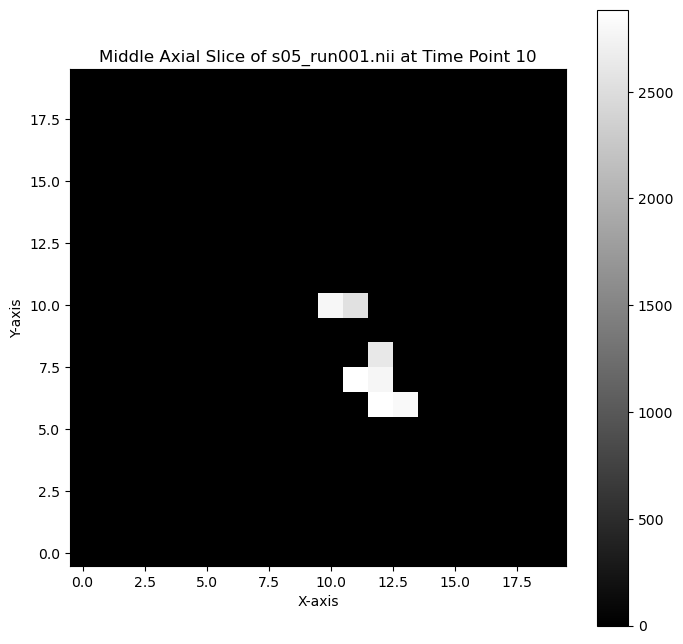

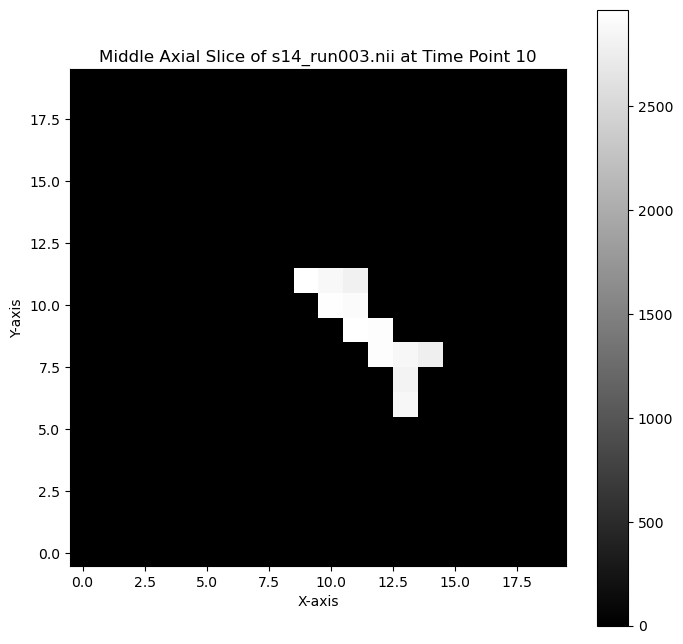

In [ ]:
def plot_nifti_with_defined_roi(file_path, time_point=6, x_bounds=(30, 50), y_bounds=(50, 70)):
    # Load the NIfTI file
    nii_img = nib.load(file_path)
    data = nii_img.get_fdata()
    
    # Extract a middle axial slice at the specified time point
    z_slice = data.shape[2] // 2  # Middle slice in the Z dimension
    slice_data = data[:, :, z_slice, time_point]
    
    # Plot the slice with the ROI highlighted
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data.T, cmap='gray', origin='lower')
    plt.colorbar()
    plt.title(f"Middle Axial Slice of {file_path.split('/')[-1]} at Time Point {time_point}")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # Highlight the ROI
    rect_x, rect_y = x_bounds[0], y_bounds[0]
    rect_width = x_bounds[1] - x_bounds[0]
    rect_height = y_bounds[1] - y_bounds[0]
    plt.gca().add_patch(plt.Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='none'))
    
    plt.show()

# Example file paths
file_path_s05 = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s05_run001.nii'
file_path_s15 = '/Users/danielledowe/Desktop/ddowe_PREPROCESSING/REDO/INPUT_DIR/s14_run003.nii'

# Plot with defined ROI
plot_nifti_with_defined_roi(file_path_s05, time_point=10) 
plot_nifti_with_defined_roi(file_path_s15, time_point=10) 
